# Final Exam Section 2 Rubric

## FINM 37400 - 2024

***

In [4]:
import pandas as pd
import numpy as np
import datetime
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)

from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from scipy.optimize import minimize
from scipy.optimize import fsolve

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)

import sys
sys.path.insert(0, '../cmds')
from treasury_cmds import *
from tradebondpair import *

### Helper Functions

In [5]:
def bootstrap_spot_rates(df):
    """
    Bootstraps spot rates from a dataframe of bond information.
    
    :param df: Pandas DataFrame with columns 'price', 'cpn rate', and 'ttm'
    :return: Pandas Series of spot rates indexed by TTM
    """
    # Ensure the DataFrame is sorted by TTM
    df = df.sort_values(by='ttm')
    
    # Initialize a dictionary to store spot rates
    spot_rates = {}

    # Iterate over each bond
    for index, row in df.iterrows():
        ttm, coupon_rate, price = row['ttm'], row['cpn rate'], row['price']
        cash_flows = [coupon_rate / 2] * round(ttm * 2)  # Semi-annual coupons
        cash_flows[-1] += 100  # Add the face value to the last cash flow

        # Function to calculate the present value of cash flows
        def pv_of_cash_flows(spot_rate):
            pv = 0
            for t in range(1, len(cash_flows) + 1):
                if t/2 in spot_rates:
                    rate = spot_rates[t/2]
                else:
                    rate = spot_rate
                pv += cash_flows[t - 1] / ((1 + rate / 2) ** t)
            return pv

        # Solve for the spot rate that sets the present value of cash flows equal to the bond price
        spot_rate_guess = (cash_flows[-1] / price) ** (1/(ttm*2)) - 1
        spot_rate = fsolve(lambda r: pv_of_cash_flows(r) - price, x0=spot_rate_guess)[0]

        # Store the calculated spot rate
        spot_rates[ttm] = spot_rate

    return pd.Series(spot_rates)

# 2. Extracting Curves

Use the selected treasury quotes in the file, `select_maturities_2017-02-07.xlsx`.

* Market quots are provided for treasury securities expiring approximately every six months over the next ten years.
* You are welcome to assume that they mature at exaclty six-year increments or to use the exact dates.
* Consider the `price` column to represent the dirty mid price. Use it as quoted, without further adjustment.

In [3]:
filepath = '../data/select_maturities_2017-02-07_v2.xlsx'
quotes = pd.read_excel(filepath).set_index('kytreasno')
# quotes['price'] = (quotes['bid'] + quotes['ask'])/2 + quotes['accrint']
quotes.head()

,date,issue date,maturity date,ttm,bid,ask,accrint,ytm,duration,outstanding,cpn rate,instrument,price
kytreasno,,,,,,,,,,,,,
206525,2017-02-07,2012-08-31,2017-08-31,0.561259,99.945312,99.984375,0.276243,0.006830,0.559690,60995,0.625,2,100.241087
206589,2017-02-07,2013-02-28,2018-02-28,1.056810,99.835938,99.875000,0.331492,0.008865,1.051226,69708,0.750,2,100.186960
207005,2017-02-07,2016-08-31,2018-08-31,1.560575,99.531250,99.570312,0.331492,0.010370,1.549334,27778,0.750,2,99.882273
206708,2017-02-07,2014-02-28,2019-02-28,2.056126,100.570312,100.617188,0.662983,0.012044,2.019424,35097,1.500,2,101.256733
206767,2017-02-07,2014-08-31,2019-08-31,2.559890,100.710938,100.734375,0.718232,0.013312,2.500337,35002,1.625,2,101.440888


### 2.1 (10pts)

Bootstrap the spot curve. Report it in both...
* discount factors, $Z$
* (semiannually compounded) discount rates, $r$



## <span style="color:red">Solution 2.1</span>

In [9]:
COMPOUNDING = 2

spot = pd.DataFrame(bootstrap_spot_rates(quotes))
spot.columns = ['rate']
spot['discount factor'] = intrate_to_discount(spot['rate'],spot.index,n_compound=COMPOUNDING)

In [10]:
spot

,rate,discount factor
0.561259,0.001425,0.999201
1.056810,0.005623,0.994084
1.560575,0.008291,0.987170
2.056126,0.008648,0.982413
2.559890,0.010396,0.973805
3.058179,0.012558,0.962440
3.561944,0.014191,0.950878
4.057495,0.015953,0.937564
4.561259,0.016923,0.926015
5.056810,0.017189,0.917090


In [45]:
QUOTE_DATE = '2017-02-28' # Adjusted so it can deal with 6mo interval
t_date = pd.to_datetime(QUOTE_DATE)
CF = pd.DataFrame(data=0, index=quotes.index, columns=quotes['maturity date'])
for i in quotes.index:
    coupon_dates = get_coupon_dates(t_date,pd.to_datetime(quotes.loc[i,'maturity date']))

    if coupon_dates is not None:
        CF.loc[i,coupon_dates] = quotes.loc[i,'cpn rate']/2

    CF.loc[i,quotes.loc[i,'maturity date']] += 100

CF = CF.resample('m',axis=1).sum()
CF.drop(columns=CF.columns[(CF==0).all()],inplace=True)
CF = CF.fillna(0).sort_index(axis=1)

MODEL = bootstrap
t_current = pd.to_datetime(QUOTE_DATE)
prices = quotes['price'][CF.index]
params_boot = estimate_rate_curve(MODEL,CF,t_current,prices)
spot_exact = pd.DataFrame({
    'maturity': params_boot[0],
    'discount factor': params_boot[1]
})
spot_exact.set_index('maturity',inplace=True)
COMPOUNDING = 2
spot_exact['semiannual'] = discount_to_intrate(spot_exact['discount factor'], spot_exact.index, n_compound=COMPOUNDING)
spot_exact

,discount factor,semiannual
maturity,,
0.503765,0.999288,0.001414
0.999316,0.994393,0.005634
1.503080,0.987643,0.008290
1.998631,0.982836,0.008681
2.502396,0.974284,0.010438
3.000684,0.962927,0.012629
3.504449,0.951387,0.014271
4.000000,0.938024,0.016059
4.503765,0.926485,0.017026


#### <span style="color:green">RUBRIC</span>
- 4 pts for correct spot rates
- 4 pts for correct discount rates
- 2 pt for using semi-annual compounding


Note if you used exactly 6mo increments, then the rates/discount factors above will be slightly different. Below is the answer if you used exact intervals. IF you used this increment and did not adjust the index to match this, then I subtracted 1 point as the rates you calculated are based on a resampled interval!

### 2.2 (10pts)

Calculate the Nelson-Siegel curve using the parameters below. (Not the NS-extended; just four parameters.)

Report both
* discount factors, $Z$
* (semiannually compounded) discount rates, $r$

In [22]:
params = pd.DataFrame(columns=['Nelson-Siegel parameters'],
                      index=['theta0', 'theta1','theta2','lambda1'],
                      data=[0.031627,-0.025166, -0.020701, 1.514887]).T
display(params)

,theta0,theta1,theta2,lambda1
Nelson-Siegel parameters,0.031627,-0.025166,-0.020701,1.514887


## <span style="color:red">Solution 2.2</span>

In [28]:
ns = pd.DataFrame(nelson_siegel(params.iloc[0,:].values,spot.index),index=spot.index,columns=['rate'])
ns['discount factor'] = intrate_to_discount(ns['rate'],ns.index,n_compound=COMPOUNDING)
ns

,rate,discount factor
0.561259,0.007590,0.995757
1.056810,0.008911,0.990648
1.560575,0.010385,0.983965
2.056126,0.011858,0.975983
2.559890,0.013314,0.966602
3.058179,0.014674,0.956273
3.561944,0.015950,0.944985
4.057495,0.017100,0.933245
4.561259,0.018163,0.920836
5.056810,0.019109,0.908306


In [53]:
# Using perfect 6mo increments
spot_exact.index = pd.to_numeric(spot_exact.index)
ns_exact = pd.DataFrame(nelson_siegel(params.iloc[0,:].values,params_boot[0]),index=spot_exact.index,columns=['rate'])
ns_exact['discount factor'] = intrate_to_discount(ns_exact['rate'],ns_exact.index,n_compound=None)
ns_exact

,rate,discount factor
maturity,,
0.503765,0.007452,0.996253
0.999316,0.008748,0.991296
1.503080,0.010214,0.984765
1.998631,0.011689,0.976910
2.502396,0.013151,0.967626
3.000684,0.014522,0.957361
3.504449,0.015809,0.946104
4.000000,0.016972,0.934366
4.503765,0.018047,0.921935


#### <span style="color:green">RUBRIC</span>
- 4 pts for correct NS extracted spot rates
- 4 pts for correct NS extracted discount factors
- 2 pts for correct compounding (semi-annual)

### 2.3 (5pts)

Plot...
* bootstrapped spot rates
* Nelson-Siegel spot rates
* provided ytm

## <span style="color:red">Solution 2.3</span>

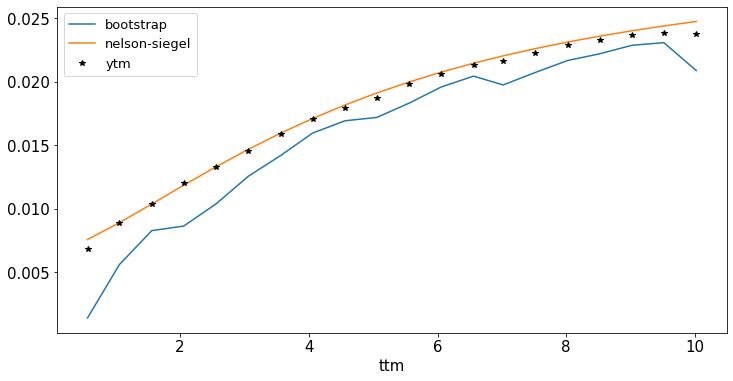

In [13]:
tab = spot[['rate']].copy()
tab.columns = ['bootstrap']
tab['nelson-siegel'] = ns[['rate']].copy()

ax = tab.plot();
(quotes[['ttm','ytm']].set_index('ttm')).plot(ax=ax,linestyle='',marker='*',color='k');

#### <span style="color:green">RUBRIC</span>
- 2 pts for plotting bootstrapped spot rates
- 2 pts for plotting nelson-siegel spot rates
- 1 pts for plotting ytm

### 2.4 (10pts)

Which of the two spot rate curves (bootstrapped or Nelson-Siegel) would be better for...
* pricing the provided sample?
* building spot rates out to 30 years?
* calculating forward rates?

For each of these three questions, be **specific** in your answer.

## <span style="color:red">Solution 2.4</span>

* Bootstrap will price perfectly in-sample.
* Nelson-Siegel can easily extend to arbitrary maturities, whereas the bootstrap will fail when TTM extends past available market data (~11 years).
* Nelson-Siegel will generate smoother forward rates

#### <span style="color:green">RUBRIC</span>
- 1 pt for correctly stating Bootstrapping in 2.4.1.
- 3 pts for correctly stating why Bootstrapping in 2.4.1
- 1 pt for correctly stating Nelson Siegel in 2.4.2
- 3 pts for correctly stating why Nelson Siegel in 2.4.2
- 1 pt for correctly stating Nelson Siegel to 2.4.3
- 1 pt for corectly stating why Nelson Siegel in 2.4.3

### 2.5 (5pts)

Consider the bootstrapped curve and its associated forward curve. (No need to calculate the forward curve.)

Conceptually, do you expect it is higher or lower than the spot-rate curve at
* $T=1$
* $T=10$

Explain.

## <span style="color:red">Solution 2.5</span>

* The forward curve is above the spot curve at $T=1$.
* The forward curve is below the spot curve at $T=10$.

This can be inferred from the relationship seen in `W.4.` The spot curve increases if and only if the forward is above the spot. And the spot is decreasing if and only if the forward is below the spot.

#### <span style="color:green">RUBRIC</span>
- 1 pt for correctly stating that the Forward Curve is ABOVE the spot curve at T=1
- 1 pt for correctly stating that the Forward Curve is BELOW the spot curve at T=10
- 3 pts for correctly explaining why

### 2.6 (5pts)

Use the bootstrapped spot curve to calculate the forward rate for $T_1=3\to T_2=3.5$.

## <span style="color:red">Solution 2.6</span>
No need to show the entire curve--just report $T=3$ to $T=3.5$.

Nearly full credit for reporting an adjacent forward rate.

In [14]:
forward = pd.DataFrame(spot['discount factor']/spot['discount factor'].shift(),index=spot.index, columns=['discount factor'])
forward['discount factor'].iloc[0] = spot['discount factor'].iloc[0]
forward['rate'] = -np.log(forward['discount factor']) / forward.index.to_series().diff().mean()

In [44]:
forward

,discount factor,rate
0.561259,0.999201,0.001606
1.056810,0.994879,0.010313
1.560575,0.993045,0.014018
2.056126,0.995181,0.009704
2.559890,0.991238,0.017677
3.058179,0.988329,0.023580
3.561944,0.987988,0.024274
4.057495,0.985998,0.028324
4.561259,0.987682,0.024896
5.056810,0.990363,0.019452


In [15]:
T2 = 3.5

# get index closest to value given Time-to-maturity are not exactly half years
idx = forward.index[abs(forward.index - T2).argmin()]

fwd_reported = forward.loc[idx,'rate']
display(f'The forward rate to {T2} years is {fwd_reported:.2%}')

'The forward rate to 3.5 years is 2.43%'

In [16]:
forward[['rate']].style.format('{:.2%}')

,rate
0.5612594113620808,0.16%
1.056810403832991,1.03%
1.560574948665298,1.40%
2.056125941136208,0.97%
2.559890485968515,1.77%
3.058179329226557,2.36%
3.561943874058864,2.43%
4.057494866529774,2.83%
4.561259411362081,2.49%
5.056810403832992,1.95%


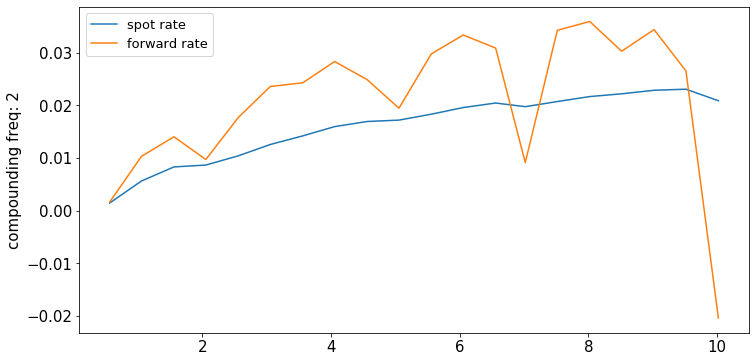

In [17]:
fig, ax = plt.subplots()
spot['rate'].plot(ax=ax)
forward['rate'].plot(ax=ax)
plt.legend(['spot rate','forward rate'])
plt.ylabel(f'compounding freq: {COMPOUNDING}')
plt.show()

#### <span style="color:green">RUBRIC</span>
- 2 pts for correct interval
- 3 pts for correct continous forward rate. Full pts will be given to this sub-part if incorrect interval is used but the forward rate is calculated correctly using this erroneous interval.

***